
Starting strategy: uniform
[Strategy=uniform] Attempting budget limit = £5,000,000


/var/folders/tn/v19h6ld131n5p0bkj6b850sr0000gn/T/ipykernel_58527/1808617991.py:79: LicenseWarning: Using the license file found in your Xpress installation. If you want to use this license and no longer want to see this message, use the following code before using the xpress module:
  xpress.init('/Applications/FICO Xpress/xpressmp/bin/xpauth.xpr')
  prob = xp.problem(name='pcentre_modular_run')


[Strategy=uniform] Solved: budget_limit=£5,000,000 -> budget_used=£4962000.00, Q=0.1852 km, opened=75 stations
[Strategy=uniform] Attempting budget limit = £4,700,000
[Strategy=uniform] Solved: budget_limit=£4,700,000 -> budget_used=£4686000.00, Q=0.1988 km, opened=71 stations
[Strategy=uniform] Attempting budget limit = £4,400,000
[Strategy=uniform] Solved: budget_limit=£4,400,000 -> budget_used=£4398000.00, Q=0.2161 km, opened=68 stations
[Strategy=uniform] Attempting budget limit = £4,100,000
[Strategy=uniform] Solved: budget_limit=£4,100,000 -> budget_used=£4098000.00, Q=0.2301 km, opened=63 stations
[Strategy=uniform] Attempting budget limit = £3,800,000
[Strategy=uniform] Solved: budget_limit=£3,800,000 -> budget_used=£3798000.00, Q=0.2433 km, opened=60 stations
[Strategy=uniform] Attempting budget limit = £3,500,000
[Strategy=uniform] Solved: budget_limit=£3,500,000 -> budget_used=£3477000.00, Q=0.2579 km, opened=56 stations
[Strategy=uniform] Attempting budget limit = £3,200,00

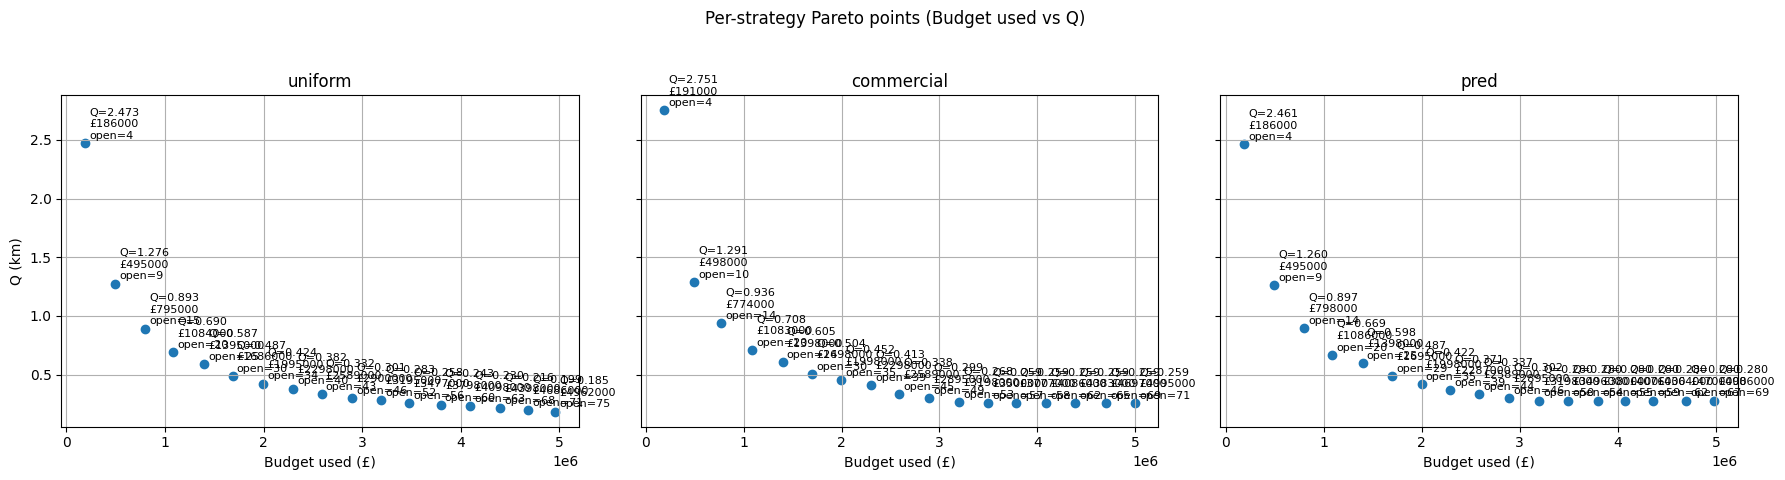

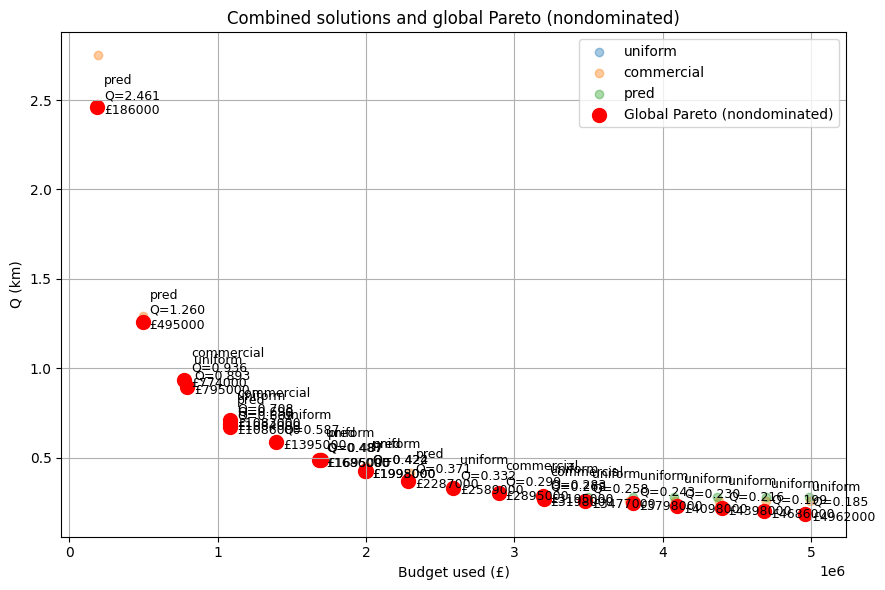

In [1]:
# Fixed and tested-looking Pareto pipeline (syntactically clean)
# Save as pareto_pipeline_fixed.py and run in an environment with xpress, numpy, pandas, matplotlib

import xpress as xp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from typing import List, Dict, Optional

# --------------------------- USER CONFIG ---------------------------
POIS_PATH = 'reduced_pois2.csv'
STATIONS_TEMPLATE = 'candidate_stations_P300_type_{}.csv'
DEMAND_TEMPLATE = 'poi_demand_per_hour_type_{}_cluster{}.csv'
EXISTING_STATION_DATA = 'station_data.csv'

STRATEGIES = ['uniform', 'commercial', 'pred']

INITIAL_BUDGET = 5_000_000
MIN_BUDGET = 100_000
BUDGET_STEP = 300_000

Tau = 2
k = 1000

COST_EXISTING = 60000
COST_NEW = 90000
ALPHA = 0.7

W_C = {
    'library': 0.8,
    'residential': 0.75,
    'school': 0.85,
    'commercial': 0.9,
    'university': 0.95,
    'hospital': 0.98
}

XPRESS_VERBOSE = False
OUTPUT_DIR = 'pareto_outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --------------------------- UTILITIES ---------------------------

def haversine_matrix(pois: pd.DataFrame,
                     stations: pd.DataFrame,
                     poi_lat: str = 'lat', poi_lon: str = 'lon',
                     st_lat: str = 'centroid_lat', st_lon: str = 'centroid_lon') -> np.ndarray:
    """Compute POI x Station distance matrix (km)."""
    poi_coords = pois[[poi_lat, poi_lon]].to_numpy()
    st_coords = stations[[st_lat, st_lon]].to_numpy()
    lat1 = np.radians(poi_coords[:, 0])[:, None]
    lon1 = np.radians(poi_coords[:, 1])[:, None]
    lat2 = np.radians(st_coords[:, 0])[None, :]
    lon2 = np.radians(st_coords[:, 1])[None, :]
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    R = 6371.0
    return R * c

# --------------------------- MODEL BUILDER ---------------------------

def build_and_solve_model(distance_matrix_km: np.ndarray,
                          stations: pd.DataFrame,
                          pois: pd.DataFrame,
                          demand_scenarios: List[List[float]],
                          capacity_vector: np.ndarray,
                          cost_vector: np.ndarray,
                          I_c: Dict[str, List[int]],
                          w_c: Dict[str, float],
                          Tau: float,
                          k: float,
                          budget_limit: float,
                          verbose: bool = False) -> Optional[Dict]:
    I, J = distance_matrix_km.shape
    prob = xp.problem(name='pcentre_modular_run')

    # Variables
    Y = {j: prob.addVariable(vartype=xp.binary, name=f'Y_{j}') for j in range(J)}
    X = {(i, j): prob.addVariable(vartype=xp.binary, name=f'X_{i}_{j}') for i in range(I) for j in range(J)}
    Z = {j: prob.addVariable(vartype=xp.integer, name=f'Z_{j}') for j in range(J)}
    Q = prob.addVariable(name='Q', lb=0)

    # Constraints
    for i in range(I):
        prob.addConstraint(xp.Sum(X[i, j] for j in range(J)) <= 1)

    for i in range(I):
        for j in range(J):
            prob.addConstraint(X[i, j] <= Y[j])

    for i in range(I):
        prob.addConstraint(xp.Sum(distance_matrix_km[i, j] * X[i, j] for j in range(J)) <= Q)

    prob.addConstraint(
        xp.Sum(cost_vector[j] * Y[j] for j in range(J))
        + k * xp.Sum((Z[j] - capacity_vector[j] * Y[j]) for j in range(J))
        <= budget_limit
    )

    for j in range(J):
        prob.addConstraint(Z[j] >= capacity_vector[j] * Y[j])
        prob.addConstraint(Z[j] <= 100 * Y[j])
        for s in range(len(demand_scenarios)):
            ds = demand_scenarios[s]
            prob.addConstraint(xp.Sum(X[i, j] * ds[i] for i in range(I)) <= Tau * Z[j])

    for s in range(len(demand_scenarios)):
        ds = demand_scenarios[s]
        for c, idx_list in I_c.items():
            if not idx_list:
                continue
            lhs = xp.Sum(X[i, j] * ds[i] for i in idx_list for j in range(J))
            rhs = w_c[c] * sum(ds[i] for i in idx_list)
            prob.addConstraint(lhs >= rhs)

    prob.setObjective(Q, sense=xp.minimize)

    xp.setOutputEnabled(verbose)
    try:
        prob.solve()
    except Exception as e:
        if verbose:
            print('Solver failed:', e)
        return None

    try:
        Q_val = prob.getSolution(Q)
    except Exception:
        return None

    Y_sol = np.array([prob.getSolution(Y[j]) for j in range(J)])
    Z_sol = np.array([prob.getSolution(Z[j]) for j in range(J)])

    budget_used = float(np.dot(cost_vector, Y_sol) + k * np.sum(Z_sol - capacity_vector * Y_sol))
    opened_count = int((Y_sol > 0.5).sum())

    opened_indices = [int(j) for j in range(J) if Y_sol[j] > 0.5]
    Z_values_opened = {int(j): int(Z_sol[j]) for j in opened_indices}

    return {'problem': prob, 'Q': Q_val, 'Y_sol': Y_sol, 'Z_sol': Z_sol, 'budget_used': budget_used,
            'opened': opened_count, 'opened_indices': opened_indices, 'Z_values_opened': Z_values_opened}

# --------------------------- PARETO FOR STRATEGY (logged + store) ---------------------------

def pareto_for_strategy_store(strategy: str,
                              pois_path: str,
                              stations_template: str,
                              demand_template: str,
                              existing_station_data_path: str,
                              initial_budget: int = INITIAL_BUDGET,
                              min_budget: int = MIN_BUDGET,
                              budget_step: int = BUDGET_STEP,
                              Tau: float = Tau,
                              k: float = k,
                              w_c: Dict[str, float] = W_C,
                              alpha: float = ALPHA,
                              cost_existing: float = COST_EXISTING,
                              cost_new: float = COST_NEW,
                              verbose: bool = XPRESS_VERBOSE) -> Optional[pd.DataFrame]:
    pois = pd.read_csv(pois_path)
    stations = pd.read_csv(stations_template.format(strategy))
    D_km = haversine_matrix(pois, stations)

    # nearest-POI category assignment
    poi_categories = pois['category'].reset_index(drop=True)
    min_row_idx_for_station = np.argmin(D_km, axis=0)
    station_categories = poi_categories.iloc[min_row_idx_for_station].reset_index(drop=True)
    stations['category'] = station_categories.values

    categories = list(w_c.keys())
    I_c = {c: pois.index[pois['category'] == c].tolist() for c in categories}

    demand_scenarios: List[List[float]] = []
    for i in range(4):
        df = pd.read_csv(demand_template.format(strategy, i))
        demand_scenarios.append(df['demand_per_hour'].tolist())

    existing_data = pd.read_csv(existing_station_data_path)
    capacity_map = dict(zip(existing_data['station_id'], existing_data['capacity']))
    capacity_vector = np.array([capacity_map.get(sid, 10) for sid in stations['snapped_station_id']])

    is_existing = stations['is_existing_station'].astype(bool).values
    station_is_commercial_by_nearest = (stations['category'] == 'commercial').values

    J = stations.shape[0]
    cost_vector = np.zeros(J, dtype=float)
    for j in range(J):
        if is_existing[j] and station_is_commercial_by_nearest[j]:
            cost_vector[j] = alpha * cost_existing
        elif is_existing[j]:
            cost_vector[j] = cost_existing
        elif station_is_commercial_by_nearest[j]:
            cost_vector[j] = alpha * cost_new
        else:
            cost_vector[j] = cost_new

    # Budgets descending (high -> low)
    budgets = list(range(int(initial_budget), int(min_budget) - 1, -int(budget_step)))
    results = []
    detailed_solutions = []

    for b in budgets:
        print(f"[Strategy={strategy}] Attempting budget limit = £{b:,}")
        sol = build_and_solve_model(D_km, stations, pois, demand_scenarios,
                                    capacity_vector, cost_vector, I_c, w_c,
                                    Tau, k, float(b), verbose=verbose)
        if sol is None:
            print(f"[Strategy={strategy}] No feasible solution at budget £{b:,}")
            continue

        print(f"[Strategy={strategy}] Solved: budget_limit=£{b:,} -> budget_used=£{sol['budget_used']:.2f}, Q={sol['Q']:.4f} km, opened={sol['opened']} stations")

        results.append({'strategy': strategy, 'budget_limit': b, 'budget_used': sol['budget_used'], 'Q': sol['Q'], 'opened': sol['opened']})

        detailed_solutions.append({
            'strategy': strategy,
            'budget_limit': int(b),
            'budget_used': float(sol['budget_used']),
            'Q': float(sol['Q']),
            'opened_count': int(sol['opened']),
            'opened_indices': sol['opened_indices'],
            'Z_values_opened': sol['Z_values_opened']
        })

    # Save detailed solutions
    if detailed_solutions:
        det_csv = os.path.join(OUTPUT_DIR, f'detailed_solutions_{strategy}.csv')
        det_pkl = os.path.join(OUTPUT_DIR, f'detailed_solutions_{strategy}.pkl')
        pd.DataFrame(detailed_solutions).to_csv(det_csv, index=False)
        with open(det_pkl, 'wb') as f:
            pickle.dump(detailed_solutions, f)
        print(f"Saved detailed solutions for strategy {strategy} to {det_csv} and {det_pkl}")

    if len(results) == 0:
        return None

    df = pd.DataFrame(results).sort_values('budget_used', ascending=True).reset_index(drop=True)
    df.to_csv(os.path.join(OUTPUT_DIR, f'pareto_points_{strategy}.csv'), index=False)
    print(f"Saved pareto points for strategy {strategy} to {os.path.join(OUTPUT_DIR, f'pareto_points_{strategy}.csv')}")

    return df

# --------------------------- DOMINATION CHECK ---------------------------

def find_nondominated(df_all: pd.DataFrame) -> pd.DataFrame:
    pts = df_all[['budget_used', 'Q']].to_numpy()
    n = pts.shape[0]
    is_nd = np.ones(n, dtype=bool)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if (pts[j, 0] <= pts[i, 0] and pts[j, 1] <= pts[i, 1]) and (pts[j, 0] < pts[i, 0] or pts[j, 1] < pts[i, 1]):
                is_nd[i] = False
                break
    return df_all[is_nd].reset_index(drop=True)

# --------------------------- MAIN: RUN ALL + PLOT + STORE DOMINANT ---------------------------

def run_all_and_store_dominant(strategies: List[str] = STRATEGIES):
    per_strategy_dfs: Dict[str, pd.DataFrame] = {}

    for s in strategies:
        print('\n' + '=' * 70)
        print(f"Starting strategy: {s}")
        df = pareto_for_strategy_store(s, POIS_PATH, STATIONS_TEMPLATE, DEMAND_TEMPLATE, EXISTING_STATION_DATA,
                                      initial_budget=INITIAL_BUDGET, min_budget=MIN_BUDGET, budget_step=BUDGET_STEP,
                                      Tau=Tau, k=k, w_c=W_C, alpha=ALPHA, cost_existing=COST_EXISTING,
                                      cost_new=COST_NEW, verbose=XPRESS_VERBOSE)
        if df is None or df.empty:
            print(f"Strategy {s} produced no feasible points.")
            continue
        per_strategy_dfs[s] = df

    # Save per-strategy files already saved in function; combine
    all_dfs: List[pd.DataFrame] = []
    for s, df in per_strategy_dfs.items():
        tmp = df.copy()
        tmp['strategy'] = s
        all_dfs.append(tmp)

    if not all_dfs:
        print('No solutions found across strategies.')
        return

    df_all = pd.concat(all_dfs, ignore_index=True)
    df_all_path = os.path.join(OUTPUT_DIR, 'pareto_points_all_strategies.csv')
    df_all.to_csv(df_all_path, index=False)
    print(f'Saved all pareto points to {df_all_path}')

    # Find non-dominated
    df_nd = find_nondominated(df_all)
    nd_path = os.path.join(OUTPUT_DIR, 'pareto_points_nondominated.csv')
    df_nd.to_csv(nd_path, index=False)
    print(f'Saved nondominated (global Pareto) points to {nd_path}')

    # Save detailed dominant solutions from per-strategy pickles
    dominant_details = []
    for _, row in df_nd.iterrows():
        strat = row['strategy']
        pkl_path = os.path.join(OUTPUT_DIR, f'detailed_solutions_{strat}.pkl')
        if not os.path.exists(pkl_path):
            continue
        with open(pkl_path, 'rb') as f:
            det_list = pickle.load(f)
        # find entry with closest budget_used
        best = None
        min_diff = float('inf')
        for det in det_list:
            diff = abs(det['budget_used'] - row['budget_used'])
            if diff < min_diff:
                min_diff = diff
                best = det
        if best is not None:
            best_copy = best.copy()
            best_copy['strategy'] = strat
            dominant_details.append(best_copy)

    dominant_csv = os.path.join(OUTPUT_DIR, 'dominant_solutions_detailed.csv')
    dominant_pkl = os.path.join(OUTPUT_DIR, 'dominant_solutions_detailed.pkl')
    if dominant_details:
        pd.DataFrame(dominant_details).to_csv(dominant_csv, index=False)
        with open(dominant_pkl, 'wb') as f:
            pickle.dump(dominant_details, f)
        print(f'Saved dominant solution details to {dominant_csv} and {dominant_pkl}')
    else:
        print('No detailed dominant solutions found to save')

    # Side-by-side plot
    n = len(strategies)
    fig, axes = plt.subplots(1, n, figsize=(6 * n, 5), sharey=True)
    if n == 1:
        axes = [axes]
    for ax, s in zip(axes, strategies):
        df = per_strategy_dfs.get(s)
        if df is None or df.empty:
            ax.set_title(s + ' (no points)')
            continue
        ax.scatter(df['budget_used'], df['Q'], marker='o')
        for _, row in df.iterrows():
            ax.annotate(f"Q={row['Q']:.3f}\n£{row['budget_used']:.0f}\nopen={row['opened']}",
                        (row['budget_used'], row['Q']), textcoords='offset points', xytext=(3, 3), fontsize=8)
        ax.set_title(s)
        ax.set_xlabel('Budget used (£)')
        ax.grid(True)
    axes[0].set_ylabel('Q (km)')
    plt.suptitle('Per-strategy Pareto points (Budget used vs Q)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    side_by_side_path = os.path.join(OUTPUT_DIR, 'pareto_per_strategy_side_by_side.png')
    plt.savefig(side_by_side_path, dpi=200)
    print(f'Saved side-by-side figure: {side_by_side_path}')

    # Combined plot with nondominated highlighted
    plt.figure(figsize=(9, 6))
    for s in strategies:
        sub = df_all[df_all['strategy'] == s]
        if sub.empty:
            continue
        plt.scatter(sub['budget_used'], sub['Q'], label=s, alpha=0.4)
    if not df_nd.empty:
        plt.scatter(df_nd['budget_used'], df_nd['Q'], color='red', s=100, label='Global Pareto (nondominated)')
        for _, row in df_nd.iterrows():
            plt.annotate(f"{row['strategy']}\nQ={row['Q']:.3f}\n£{row['budget_used']:.0f}",
                         (row['budget_used'], row['Q']), textcoords='offset points', xytext=(5, -5), fontsize=9)
    plt.xlabel('Budget used (£)')
    plt.ylabel('Q (km)')
    plt.title('Combined solutions and global Pareto (nondominated)')
    plt.legend()
    plt.grid(True)
    combined_path = os.path.join(OUTPUT_DIR, 'pareto_combined_nondominated.png')
    plt.tight_layout()
    plt.savefig(combined_path, dpi=200)
    print(f'Saved combined Pareto figure with nondominated highlighted: {combined_path}')

    print('\nGLOBAL NONDOMINATED SOLUTIONS:')
    print(df_nd)
    print('\nDetailed dominant solutions saved (if any) to:')
    print(dominant_csv)
    print(dominant_pkl)

# --------------------------- ENTRYPOINT ---------------------------
if __name__ == '__main__':
    run_all_and_store_dominant(STRATEGIES)
